In [1]:
#Imported modules
import requests
import matplotlib.pyplot as plt
import torch
from torch import nn
from torchvision.models import resnet50
import torchvision.transforms as T
import customtkinter as ctk
from tkinter import filedialog as fd
from PIL import Image, ImageTk
from matplotlib.backends.backend_tkagg import FigureCanvasTkAgg
import tkinter

c:\Users\Lenovo\AppData\Local\Programs\Python\Python310\lib\site-packages\tqdm\auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
class DETRdemo(nn.Module):
    def __init__(self, num_classes, hidden_dim=256, nheads=8, num_encoder_layers=6, num_decoder_layers=6):
        super().__init__()

        # create ResNet-50 backbone
        self.backbone = resnet50()
        del self.backbone.fc
        print(self.backbone)

        # create conversion layer
        self.conv = nn.Conv2d(2048, hidden_dim, 1)

        # create a default PyTorch transformer
        self.transformer = nn.Transformer(
            hidden_dim, nheads, num_encoder_layers, num_decoder_layers)

        # prediction heads, one extra class for predicting non-empty slots
        # note that in baseline DETR linear_bbox layer is 3-layer MLP
        self.linear_class = nn.Linear(hidden_dim, num_classes + 1)
        self.linear_bbox = nn.Linear(hidden_dim, 4)

        # output positional encodings (object queries)
        self.query_pos = nn.Parameter(torch.rand(100, hidden_dim))

        # spatial positional encodings
        # note that in baseline DETR we use sine positional encodings
        self.row_embed = nn.Parameter(torch.rand(50, hidden_dim // 2))
        self.col_embed = nn.Parameter(torch.rand(50, hidden_dim // 2))

    def forward(self, inputs):
        # propagate inputs through ResNet-50 up to avg-pool layer
        x = self.backbone.conv1(inputs)
        x = self.backbone.bn1(x)
        x = self.backbone.relu(x)
        x = self.backbone.maxpool(x) #Dilakukan pooling layer dengan nilai average (rata-rata)

        x = self.backbone.layer1(x)
        x = self.backbone.layer2(x)
        x = self.backbone.layer3(x)
        x = self.backbone.layer4(x)

        # convert from 2048 to 256 feature planes for the transformer
        h = self.conv(x)

        # construct positional encodings
        H, W = h.shape[-2:]
        pos = torch.cat([
            self.col_embed[:W].unsqueeze(0).repeat(H, 1, 1),
            self.row_embed[:H].unsqueeze(1).repeat(1, W, 1),
        ], dim=-1).flatten(0, 1).unsqueeze(1)

        # propagate through the transformer
        h = self.transformer(pos + 0.1 * h.flatten(2).permute(2, 0, 1), self.query_pos.unsqueeze(1)).transpose(0, 1)
        
        # finally project transformer outputs to class labels and bounding boxes
        return {'pred_logits': self.linear_class(h), 
                'pred_boxes': self.linear_bbox(h).sigmoid()}

In [3]:
detr = DETRdemo(num_classes=91)
state_dict = torch.hub.load_state_dict_from_url(
    url='https://dl.fbaipublicfiles.com/detr/detr_demo-da2a99e9.pth',
    map_location='cpu', check_hash=True)
detr.load_state_dict(state_dict)
detr.eval()

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (downsample): Sequential(
        (0): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 

DETRdemo(
  (backbone): ResNet(
    (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu): ReLU(inplace=True)
    (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (layer1): Sequential(
      (0): Bottleneck(
        (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace=True)
        (downsample): Sequential(
        

In [4]:
# COCO classes
CLASSES = [
    'N/A', 'person', 'bicycle', 'car', 'motorcycle', 'airplane', 'bus',
    'train', 'truck', 'boat', 'traffic light', 'fire hydrant', 'N/A',
    'stop sign', 'parking meter', 'bench', 'bird', 'cat', 'dog', 'horse',
    'sheep', 'cow', 'elephant', 'bear', 'zebra', 'giraffe', 'N/A', 'backpack',
    'umbrella', 'N/A', 'N/A', 'handbag', 'tie', 'suitcase', 'frisbee', 'skis',
    'snowboard', 'sports ball', 'kite', 'baseball bat', 'baseball glove',
    'skateboard', 'surfboard', 'tennis racket', 'bottle', 'N/A', 'wine glass',
    'cup', 'fork', 'knife', 'spoon', 'bowl', 'banana', 'apple', 'sandwich',
    'orange', 'broccoli', 'carrot', 'hot dog', 'pizza', 'donut', 'cake',
    'chair', 'couch', 'potted plant', 'bed', 'N/A', 'dining table', 'N/A',
    'N/A', 'toilet', 'N/A', 'tv', 'laptop', 'mouse', 'remote', 'keyboard',
    'cell phone', 'microwave', 'oven', 'toaster', 'sink', 'refrigerator', 'N/A',
    'book', 'clock', 'vase', 'scissors', 'teddy bear', 'hair drier',
    'toothbrush'
]

# colors for visualization
COLORS = [[0.000, 0.447, 0.741], [0.850, 0.325, 0.098], [0.929, 0.694, 0.125],
        [0.494, 0.184, 0.556], [0.466, 0.674, 0.188], [0.301, 0.745, 0.933]]

In [5]:
# standard PyTorch mean-std input image normalization
transform = T.Compose([
    T.Resize(800),
    T.ToTensor(),
    T.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])

# for output bounding box post-processing
def box_cxcywh_to_xyxy(x):
    x_c, y_c, w, h = x.unbind(1)
    b = [(x_c - 0.5 * w), (y_c - 0.5 * h),
         (x_c + 0.5 * w), (y_c + 0.5 * h)]
    return torch.stack(b, dim=1)

def rescale_bboxes(out_bbox, size):
    img_w, img_h = size
    b = box_cxcywh_to_xyxy(out_bbox)
    b = b * torch.tensor([img_w, img_h, img_w, img_h], dtype=torch.float32)
    return b

In [6]:
def detect(im, model, transform):
    # mean-std normalize the input image (batch-size: 1)
    img = transform(im).unsqueeze(0)

    # demo model only support by default images with aspect ratio between 0.5 and 2
    # if you want to use images with an aspect ratio outside this range
    # rescale your image so that the maximum size is at most 1333 for best results
    assert img.shape[-2] <= 1600 and img.shape[-1] <= 1600, 'demo model only supports images up to 1600 pixels on each side'

    # propagate through the model
    outputs = model(img)

    # keep only predictions with 0.7+ confidence
    probas = outputs['pred_logits'].softmax(-1)[0, :, :-1]
    keep = probas.max(-1).values > 0.7

    # convert boxes from [0; 1] to image scales
    bboxes_scaled = rescale_bboxes(outputs['pred_boxes'][0, keep], im.size)
    return probas[keep], bboxes_scaled

In [7]:
def plot_results(pil_img, prob, boxes):
    f = plt.figure(figsize=(16,10))
    plt.imshow(pil_img)
    ax = plt.gca()
    for p, (xmin, ymin, xmax, ymax), c in zip(prob, boxes.tolist(), COLORS * 100):
        ax.add_patch(plt.Rectangle((xmin, ymin), xmax - xmin, ymax - ymin, fill=False, color=c, linewidth=3))
        cl = p.argmax()
        text = f'{CLASSES[cl]}: {p[cl]:0.2f}'
        ax.text(xmin, ymin, text, fontsize=15,
                bbox=dict(facecolor='yellow', alpha=0.5))
    plt.axis('off')
    plt.show()
    return f

tensor([[3.8019e-10, 8.9667e-01, 9.4090e-05,  ..., 1.3928e-05, 5.4490e-09,
         5.5273e-08],
        [2.7009e-10, 6.3244e-03, 5.9368e-04,  ..., 5.3541e-08, 1.2400e-08,
         3.6748e-09],
        [2.0438e-10, 6.0607e-04, 9.8197e-04,  ..., 1.9542e-05, 7.6853e-08,
         2.4745e-07],
        ...,
        [1.4905e-10, 5.9917e-03, 1.3372e-04,  ..., 1.5848e-08, 4.0654e-10,
         4.3664e-09],
        [2.6604e-10, 9.8356e-01, 9.9757e-05,  ..., 6.7196e-06, 1.6130e-08,
         6.1624e-07],
        [6.1050e-11, 9.9788e-01, 9.6878e-06,  ..., 2.9442e-06, 1.0599e-08,
         1.3093e-07]], grad_fn=<IndexBackward0>)
tensor([[255.8823, 207.9825, 270.7640, 220.3452],
        [181.4374, 205.2730, 214.1799, 243.8837],
        [565.9837, 232.6325, 578.0611, 248.4993],
        [519.7985, 219.5576, 538.2513, 246.1375],
        [481.5009, 195.2387, 524.7828, 341.6536],
        [189.4137, 218.5804, 321.2231, 304.1736],
        [ 23.9861, 184.2090,  43.3426, 209.0284],
        [609.9705, 187.6515,

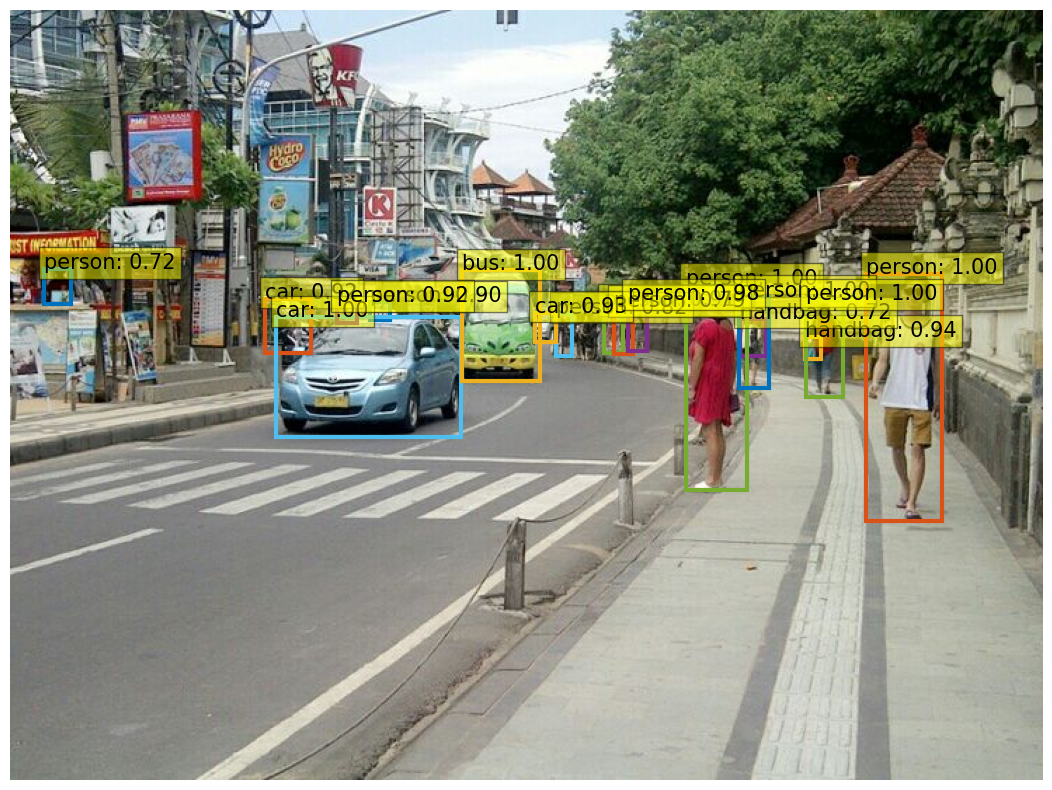

In [8]:
import customtkinter as ctk
from tkinter import filedialog as fd
from PIL import Image, ImageTk

ctk.set_appearance_mode("dark")
ctk.set_default_color_theme("blue")

class App(ctk.CTkToplevel):
    def __init__(self):
        super().__init__()
        self.geometry = "500x500"
        self.title("Object Detection With DETR")
        self.protocol("WM_DELETE_WINDOW", self.on_close)
        self.write_file = False
        self.result = None

        # =========== making 2 frames ==========
        self.grid_columnconfigure(1, weight=1)
        self.grid_rowconfigure(0, weight=1)

        self.frame_left = ctk.CTkFrame(master=self, width=200, corner_radius=0)
        self.frame_left.grid(row=0, column=0, sticky="nswe")

        self.frame_right = ctk.CTkFrame(master=self)
        self.frame_right.grid(row=0, column=1, sticky="nswe", padx=10, pady=10)

        self.frame_left.grid_rowconfigure(0, minsize=20)
        self.frame_left.grid_rowconfigure(5, weight=5)
        self.frame_left.grid_rowconfigure(8, minsize=35)
        # ========== configuring content =======

        # =========== left frame ==============
        self.input_label = ctk.CTkLabel(master=self.frame_left, text="Insert Image File", text_font=("Roboto Medium", 16))
        self.input_label.grid(row=1, column=0, pady=15, padx=15, sticky="n")

        self.input_button = ctk.CTkButton(master=self.frame_left, text="Insert Image", command=self.select_file)
        self.input_button.grid(row=2, column=0, pady=15, padx=15, sticky="n")

        self.start_btn = ctk.CTkButton(master=self.frame_left, text="Start Process", command=self.start_process, fg_color="green", hover_color="green", border_color="dark_green")
        self.start_btn.grid(row=3, column=0, padx=15, pady=15, sticky="n")

        # =========== Right frame ==============
        
    def select_file(self):
        file_type = [('Image File', ['*.jpg', '*.jpeg', '*.png'])]
        path_to_file = fd.askopenfilename(title="Select a image file", filetypes=file_type)            
        self.image = Image.open(path_to_file)
    
    def start_process(self):
        try:
            self.canvas.get_tk_widget().destroy()

        except:
            _ = ""
        finally:
            scores, boxes = detect(self.image, detr, transform)
            print(scores)
            print(boxes)
            print(detr)
            f = plot_results(self.image, scores, boxes)
            self.canvas = FigureCanvasTkAgg(f, master=self.frame_right)
            self.canvas.draw()
            self.canvas.get_tk_widget().pack(side=tkinter.TOP, fill=tkinter.BOTH, expand=1)

    def on_close(self):
        self.destroy()

app = App()
app.mainloop()